In [1]:
from ebisim import Device, Q_E, EPS_0
from ebisim.simulation._radial_dist import boltzmann_radial_potential_linear_density_ebeam, boltzmann_radial_potential_linear_density_ebeam_sor
import numpy as np
import matplotlib.pyplot as plt


In [2]:
?Device.get

Signature:
Device.get(
    current,
    e_kin,
    r_e,
    length,
    v_ax,
    b_ax,
    r_dt,
    v_ra=None,
    j=None,
    fwhm=None,
    n_grid=200,
    r_dt_bar=None,
)
Docstring:
Factory method for defining a device.

Parameters
----------
current : float
    <A>
    Electron beam current.
e_kin : float
    <eV>
    Uncorrected electron beam energy.
r_e : float
    <m>
    Electron beam radius.
length : float
    <m>
    Trap length.
v_ax : float
    <V>
    Axial barrier bias.
b_ax : float
    <T>
    Axial magnetic flux density in the trap.
r_dt : float
    <m>
    Drift tube radius.
v_ra : float, optional
    <V>
    Override for radial trap depth, by default None.
    Only effective if ModelOptions.RADIAL_DYNAMICS=False.
j : float, optional
    <A/cm^2>
    Override for current density, by default None.
fwhm : float, optional
    <eV>
    Override for the electron beam energy spread, by default None.
    Only effective if ModelOptions.RADIAL_DYNAMICS=False.
n_grid : int, o

In [3]:
dev = Device.get(
    current=1,
    e_kin=5000,
    r_e=100e-6,
    length=0.8,
    v_ax = 1000,
    b_ax = 2,
    r_dt=5e-3,
    n_grid=400
)

In [4]:
?boltzmann_radial_potential_linear_density_ebeam

Signature:      
boltzmann_radial_potential_linear_density_ebeam(
    r,
    current,
    r_e,
    e_kin,
    nl,
    kT,
    q,
    first_guess=None,
    ldu=None,
)
Call signature:  boltzmann_radial_potential_linear_density_ebeam(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function boltzmann_radial_potential_linear_density_ebeam at 0x7f50ce941290>)
File:            ~/Repos/EBISSimulation/ebisim/simulation/_radial_dist.py
Docstring:      
Solves the Boltzmann Poisson equation for a static background charge density rho_0 and particles
with line number density n, Temperature kT and charge state q.
The electron beam charge density is computed from a uniform current density and
the iteratively corrected velocity profile of the electron beam.

Below, nRS and nCS are the number of radial sampling points and charge states.

Solution is found through Newton Raphson iterations, cf. [PICNPS]_.

Parameters
----------
r : np.ndarray
    <m>
    Radial grid poin

In [5]:
phi, nax, shape = boltzmann_radial_potential_linear_density_ebeam(
    r=dev.rad_grid,
    current=dev.current,
    r_e=dev.r_e,
    e_kin=dev.e_kin,
    nl=0.,
    kT=1.,
    q=1,
    first_guess=None,
    ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u),
)

In [6]:
phi_s, nax_s, shape_s = boltzmann_radial_potential_linear_density_ebeam_sor(
    r=dev.rad_grid,
    current=dev.current,
    r_e=dev.r_e,
    e_kin=dev.e_kin,
    nl=0.,
    kT=1.,
    q=1,
    first_guess=None,
    ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u),
)

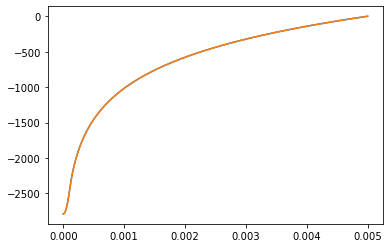

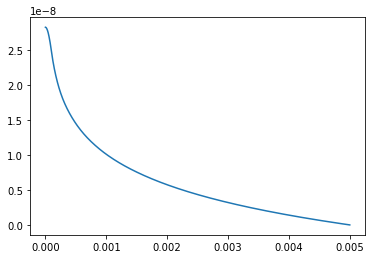

In [7]:
plt.subplots()
plt.plot(dev.rad_grid, phi)
plt.plot(dev.rad_grid, phi_s)
plt.show()
plt.subplots()
plt.plot(dev.rad_grid, phi-phi_s)
plt.show()

In [8]:
%timeit boltzmann_radial_potential_linear_density_ebeam(r=dev.rad_grid, current=dev.current, r_e=dev.r_e, e_kin=dev.e_kin, nl=1e11, kT=40., q=1, first_guess=None, ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u))
%timeit boltzmann_radial_potential_linear_density_ebeam_sor(r=dev.rad_grid, current=dev.current, r_e=dev.r_e, e_kin=dev.e_kin, nl=1e11, kT=40., q=1, first_guess=None, ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u))

2.41 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
788 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
def cmp(nl, kT, q):
    phi, nax, shape = boltzmann_radial_potential_linear_density_ebeam(
        r=dev.rad_grid,
        current=dev.current,
        r_e=dev.r_e,
        e_kin=dev.e_kin,
        nl=nl,
        kT=kT,
        q=q,
        first_guess=None,
        ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u),
    )
    phi_s, nax_s, shape_s = boltzmann_radial_potential_linear_density_ebeam_sor(
        r=dev.rad_grid,
        current=dev.current,
        r_e=dev.r_e,
        e_kin=dev.e_kin,
        nl=nl,
        kT=kT,
        q=q,
        first_guess=None,
        ldu=(dev.rad_fd_l, dev.rad_fd_d, dev.rad_fd_u),
    )
    fig, axs = plt.subplots(3, figsize=(20,15))
#     axs[0].semilogx(dev.rad_grid, 1-(phi/phi[0]))
#     axs[0].loglog(dev.rad_grid, 1-(phi_s/phi_s[0]), "--")
    axs[0].semilogx(dev.rad_grid, phi)
    axs[0].plot(dev.rad_grid, phi_s, "--")
#     axs[1].semilogx(dev.rad_grid, phi-phi_s)
    axs[1].semilogx(dev.rad_grid, -EPS_0/dev.rad_grid*np.gradient(dev.rad_grid*np.gradient(phi, dev.rad_grid),dev.rad_grid))
    
    axs[1].plot(dev.rad_grid, -EPS_0/dev.rad_grid*np.gradient(dev.rad_grid*np.gradient(phi_s, dev.rad_grid),dev.rad_grid), "--")
#     axs[1].set_yscale("symlog")
    
    axs[2].loglog(dev.rad_grid, Q_E*nax.T*shape.T,)
    axs[2].loglog(dev.rad_grid, Q_E*nax_s.T*shape_s.T, "--")
    axs[2].set_ylim(1e-6, 10)
    plt.show()
    print(nax * np.trapz(dev.rad_grid*shape, dev.rad_grid)*2*np.pi)
    print(nax_s * np.trapz(dev.rad_grid*shape_s, dev.rad_grid)*2*np.pi)    
    print(phi[0])
    print(phi_s[0])
    
    print(shape[0,0]-shape.max())

/home/hpahl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/hpahl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


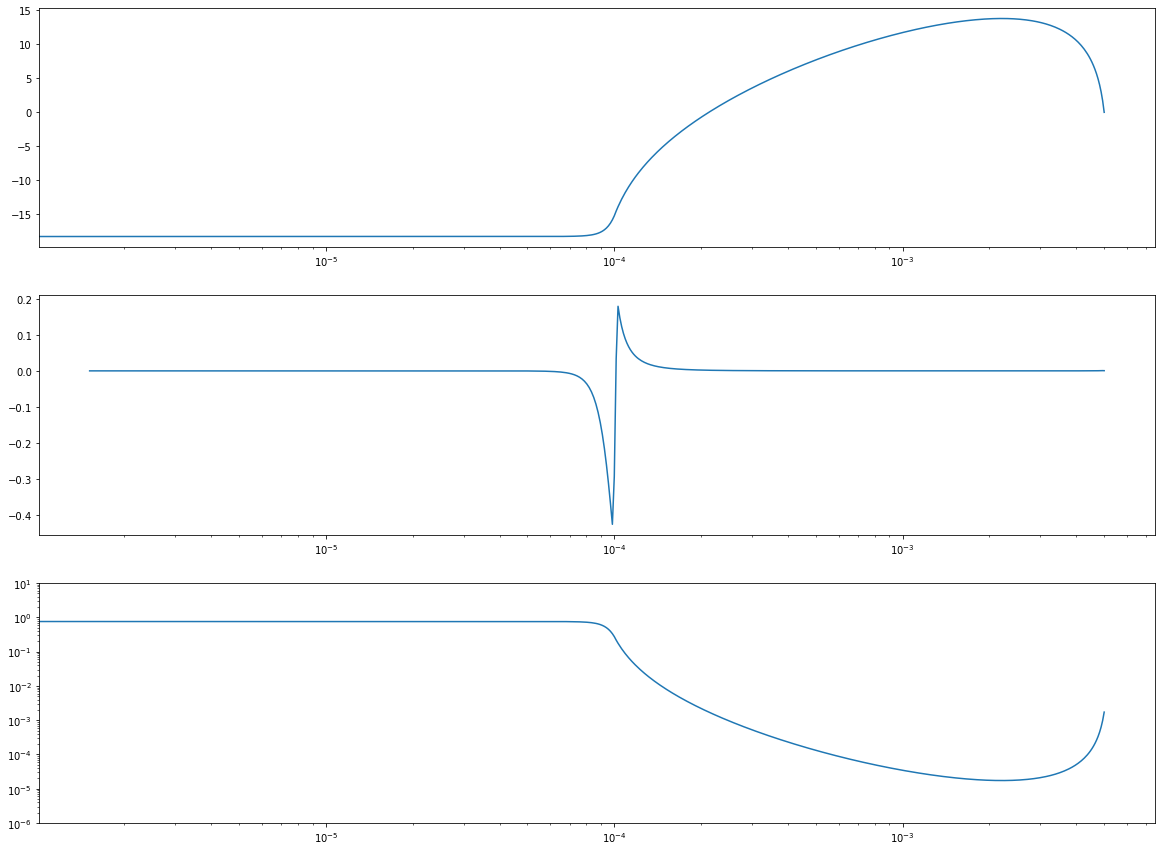

[[2.1e+11]]
[[nan]]
-18.264662610117355
nan
0.0


In [12]:
cmp(7*3.00e10, 3, 1)